In [1]:
# requirements
!pip install --upgrade pip
!pip install --upgrade pandas scikit-learn
!pip install --upgrade xgboost

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 1.5 MB 12.2 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.1.1
    Uninstalling pip-20.1.1:
      Successfully uninstalled pip-20.1.1
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWa

## 1.1. Importanción de librerias

In [2]:
import os, types
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from botocore.client import Config
import ibm_boto3
import logging

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [3]:
# create logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

# create formatter
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)

In [4]:
RANDOM_STATE = 288

## 1.3. Carga de datos

# Carga de datos
df = pd.read_csv('../src/data/ds_job.csv')
df.set_index('empleado_id', inplace=True)

In [5]:
# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.


if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_1e52a7ab76914f51815f3bc4beaef35b = 'https://s3.eu-geo.objectstorage.softlayer.net'
else:
    endpoint_1e52a7ab76914f51815f3bc4beaef35b = 'https://s3.eu-geo.objectstorage.service.networklayer.com'

client_1e52a7ab76914f51815f3bc4beaef35b = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='-WrN4cg5gACPjvar-fZ3FgZcWI9-TmoM-GjkXmr23kiU',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_1e52a7ab76914f51815f3bc4beaef35b)

body = client_1e52a7ab76914f51815f3bc4beaef35b.get_object(Bucket='tfmue-donotdelete-pr-wyxiulc08c8m9b',Key='ds_job.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object

def __iter__(self): 
    return 0

if not hasattr(body, "__iter__"): 
    body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.set_index('empleado_id', inplace=True)

In [6]:
# División de los datos en train y set
X, y = df.drop('target', axis=1), df['target']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15326, 12), (15326,), (3832, 12), (3832,))

In [8]:
class BaseTransformer(BaseEstimator, TransformerMixin):
    """ Transformer que deja el dataset tal como esta,
        el objetivo de este es ser utilizado en el GS
        para probar el no hacer nada para un determinado
        step.
    """
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return X
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)
    

class OutliersTransformer(BaseTransformer):
    """
        Transformer para el tratamiento de outliers.
        
        Parameters:
        factor (float): Factor por el cual de termina si un valor es un outlier
            de la columna o no.
        method (str): Permite dos métodos de imputación,'drop'
            para eliminar los outliers y 'cap' para limitarlos en el upper_bound 
            o el lower_bound.
        exclude_cols: Lista de columnas excluidas del transformador o None para 
        incluirlas todas
        
    """
    def __init__(self, method='drop', factor=1.5, exclude_cols=None):
        self.method = method
        self.factor = factor
        self.exclude_cols = exclude_cols
        
    def _outlier_removal(self,X,y=None):
        X = pd.Series(X).copy()
        if X.name not in self.exclude_cols:
            q1 = X.quantile(0.25)
            q3 = X.quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - (self.factor * iqr)
            upper_bound = q3 + (self.factor * iqr)
            X.loc[((X < lower_bound) | (X > upper_bound))] = np.nan 
        return pd.Series(X)
    
    def _outlier_cap(self,X,y=None):
        X = pd.Series(X).copy()
        if X.name not in self.exclude_cols:
            q1 = X.quantile(0.25)
            q3 = X.quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - (self.factor * iqr)
            upper_bound = q3 + (self.factor * iqr)
            X.loc[X < lower_bound] = lower_bound
            X.loc[X > upper_bound] = upper_bound
        return pd.Series(X)
    
    def fit(self,X,y=None):
        self.exclude_cols = set(self.exclude_cols) if self.exclude_cols else set()
        return self
    
    def transform(self,X,y=None):
        if self.method == 'drop':
            return X.apply(self._outlier_removal)
        elif self.method == 'cap':
            return X.apply(self._outlier_cap)
        else:
            return X
        
        
class Preprocessor(BaseTransformer):
    """
    Clase hecha especificamente en un GS que permite probar diferentes
    transformadores dentro de un mismo diccionario de params
    
    Parameters:
    cols (list): Lista de columnas sobre las que se aplicara el preprocessado
                o None para usarlas todas.
    """
    NUM_COLS = {'horas_formacion', 'indice_desarrollo_ciudad'}
    CAT_COLS = {
        'ultimo_nuevo_trabajo', 'tamano_compania', 'experiencia', 'educacion', 
        'universidad_matriculado', 'nivel_educacion', 'genero', 'ciudad'
    }
    
    def __init__(self, cols=None, transformer=ColumnTransformer(transformers=[
            # Workaround to enable pipelines parameters in gridsearchcv 
            ('num', Pipeline(steps=[
                    ('outliers', OutliersTransformer()),
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', MinMaxScaler())
                ]), []),
            ('cat', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
                ]), [])
            ])):
        
        self.cols = cols
        self.transformer = transformer
        self.categorical = []
        self.numerical = []
        self.numeric_tf = None
        self.categorical_tf = None
        
        
    def _fit(self):
        self.cols = self.cols or tuple(self.NUM_COLS | self.CAT_COLS)
        if self.cols:
            for col in self.cols:
                if col in self.CAT_COLS:
                    self.categorical.append(col)
                elif col in self.NUM_COLS:
                    self.numerical.append(col)
            
            if self.numerical:
                self.numeric_tf = Pipeline(steps=[
                    ('outliers', OutliersTransformer()),
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', MinMaxScaler())
                ])

            if self.categorical:
                self.categorical_tf = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
                ])
                
        transformers = []
        if self.numeric_tf:
            transformers.append(('num', self.numeric_tf, self.numerical))
        if self.categorical_tf:
            transformers.append(('cat', self.categorical_tf, self.categorical))
        
        self.transformer = ColumnTransformer(transformers=transformers)
    
    def fit(self, X, y=None):
        self._fit()
        self.column_transformer.fit(X, y)
        return self
    
    def transform(self, X):
        if not self.transformer:
            return X
        return self.transformer.transform(X)
    
    def fit_transform(self, X, y=None):
        self._fit()
        return self.transformer.fit_transform(X, y)
    

In [9]:
all_cols = tuple(X_train.columns.values)
pca = PCA()
X_preprocessed = pd.DataFrame(Preprocessor(cols=all_cols).fit_transform(X_train))

2021-06-24 18:28:21,948 - INFO - Note: NumExpr detected 56 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-06-24 18:28:21,949 - INFO - NumExpr defaulting to 8 threads.


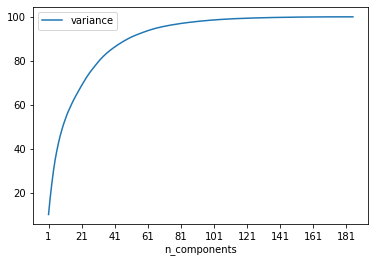

In [10]:
pca.fit(X_preprocessed)
pd.DataFrame({
    'n_components': range(1, len(X_preprocessed.columns) + 1),
    'variance': np.cumsum(pca.explained_variance_ratio_)*100         
    }).set_index('n_components').plot(xticks=range(1, X_preprocessed.shape[1], 20))

In [11]:
X_preprocessed.shape[1]

185

Observamos que la dimensionalidad puede llegar a 185 usando todas las columnas, pero que aplicando un PCA de 40 features tendriamos aún más del 80% de varianza explicada

In [12]:
class Clf(BaseEstimator):
    """Base model used to host classifiers on GridSearchCV"""
    def __init__(self, estimator=DummyClassifier()):
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

Estos seran todos los parámetros disponibles en el gridsearchcv (además de los propios del estimator escogido):

In [13]:
make_pipeline(Preprocessor(), PCA(), Clf()).get_params()

{'memory': None,
 'steps': [('preprocessor', Preprocessor()), ('pca', PCA()), ('clf', Clf())],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'pca': PCA(),
 'clf': Clf(),
 'preprocessor__cols': None,
 'preprocessor__transformer__n_jobs': None,
 'preprocessor__transformer__remainder': 'drop',
 'preprocessor__transformer__sparse_threshold': 0.3,
 'preprocessor__transformer__transformer_weights': None,
 'preprocessor__transformer__transformers': [('num',
   Pipeline(steps=[('outliers', OutliersTransformer()),
                   ('imputer', SimpleImputer(strategy='median')),
                   ('scaler', MinMaxScaler())]),
   []),
  ('cat',
   Pipeline(steps=[('imputer',
                    SimpleImputer(fill_value='missing', strategy='constant')),
                   ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))]),
   [])],
 'preprocessor__transformer__verbose': False,
 'preprocessor__transformer__num': Pipeline(steps=[('outliers', OutliersTransformer()),
            

## Backward Feature Selection 

### Iteración 1

Hayamos todas las combinaciones posibles de columnas:

In [102]:
comb = [itertools.combinations(all_cols, x) for x in range(1, len(all_cols)+1)]
len(list(itertools.chain.from_iterable(comb)))

4095

Se pueden formar 4095 combinaciones de columnas, probandolas todas en conjunto con los diferentes preprocesados surgirian un número de fits tan grande que sería imposible que el proceso acabase en semanas, por lo que aplicaremos backward feature selection para ir reduciendo el número de columnas a medida que vamos evaluando el modelo. De entrada vamos a escoger las combinaciónes que tengan 11 o variables, o lo que viene a ser lo mismo, usar todas las variables o descartar alguna.

In [103]:
comb = [itertools.combinations(all_cols, x) for x in range(11, len(all_cols)+1)]
col_comb = list(itertools.chain.from_iterable(comb))
len(col_comb)

13

A partir de aquí podemos probar todas las posibles combinaciones de columnas con todos los preprocesados y modelos que queramos. Empezaremos por Logistic Regression ya que es el modelo más rápido de entrenar

In [107]:
param_grid = {
    'preprocessor__cols': col_comb,
    'preprocessor__transformer__num__outliers__exclude_cols': [['indice_desarrollo_ciudad']],
    'preprocessor__transformer__num__outliers__method': [None, 'cap', 'drop'],
    'preprocessor__transformer__num__scaler': [MinMaxScaler(), StandardScaler()],
    'preprocessor__transformer__num__imputer': [SimpleImputer(strategy='median'), SimpleImputer(strategy='mean')],
    'preprocessor__transformer__cat__imputer': [
        SimpleImputer(strategy='constant', fill_value='missing'), 
        BaseTransformer()], # BaseTransformer() is the same as do nothing
    'preprocessor__transformer__cat__ohe': [
        OneHotEncoder(handle_unknown='ignore', sparse=False),
        OneHotEncoder(drop='first', sparse=False), 
        OneHotEncoder(drop='if_binary', sparse=False)],
    'pca__n_components': [None, 40, 80],#, 100, 125, None],
    'clf__estimator': [LogisticRegression()],
    'clf__estimator__random_state': [RANDOM_STATE],
}

In [108]:
logger.info('Starting Auto ML pipe...')

2021-06-24 13:02:49,598 - INFO - Starting Auto ML pipe...


In [109]:
auto_ml_pipe = make_pipeline(Preprocessor(), PCA(), Clf())
gs = GridSearchCV(auto_ml_pipe, param_grid, cv=2, n_jobs=-1, verbose=3, scoring='accuracy', return_train_score=True)
gs.fit(X_train, y_train)
results1 = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').reset_index()
#results[['param_clf__estimator', 'mean_test_score', 'mean_train_score', 'param_pca__n_components', 'param_columntransformer__num__scaler', 'param_pca__n_components', 'param_columntransformer__num__imputer', 'param_columntransformer__cat__ohe']]

Fitting 2 folds for each of 2808 candidates, totalling 5616 fits


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.78037322 0.78037322 0.78037322 ... 0.78089521 0.78122145 0.78161295]
  category=UserWarning
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the train scores are non-finite: [0.78683283 0.78683283 0.78683283 ... 0.78343991 0.78415764 0.78330941]
  category=UserWarning


In [110]:
logger.info('Best estimator score:')
logger.info(gs.best_estimator_.score(X_test, y_test))

2021-06-24 13:27:40,982 - INFO - Best estimator score:
2021-06-24 13:27:41,007 - INFO - 0.7875782881002088


In [111]:
logger.info('Best estimator params:')
logger.info(gs.best_params_)

2021-06-24 13:27:41,011 - INFO - Best estimator params:
2021-06-24 13:27:41,012 - INFO - {'clf__estimator': LogisticRegression(random_state=288), 'clf__estimator__random_state': 288, 'pca__n_components': 80, 'preprocessor__cols': ('ciudad', 'indice_desarrollo_ciudad', 'genero', 'experiencia_relevante', 'nivel_educacion', 'educacion', 'experiencia', 'tamano_compania', 'tipo_compania', 'ultimo_nuevo_trabajo', 'horas_formacion'), 'preprocessor__transformer__cat__imputer': BaseTransformer(), 'preprocessor__transformer__cat__ohe': OneHotEncoder(drop='if_binary', sparse=False), 'preprocessor__transformer__num__imputer': SimpleImputer(strategy='median'), 'preprocessor__transformer__num__outliers__exclude_cols': ['indice_desarrollo_ciudad'], 'preprocessor__transformer__num__outliers__method': 'drop', 'preprocessor__transformer__num__scaler': StandardScaler()}


In [112]:
results1[:5]

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator,param_clf__estimator__random_state,param_pca__n_components,param_preprocessor__cols,param_preprocessor__transformer__cat__imputer,...,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,2441,0.396559,0.018871,0.067223,0.007405,LogisticRegression(random_state=288),288,80,"(ciudad, indice_desarrollo_ciudad, genero, exp...",BaseTransformer(),...,{'clf__estimator': LogisticRegression(random_s...,0.782853,0.785071,0.783962,0.001109,1,0.783244,0.783766,0.783505,0.000261
1,2432,0.376206,0.021068,0.077222,0.003265,LogisticRegression(random_state=288),288,80,"(ciudad, indice_desarrollo_ciudad, genero, exp...",BaseTransformer(),...,{'clf__estimator': LogisticRegression(random_s...,0.782983,0.784680,0.783831,0.000848,2,0.783114,0.783244,0.783179,0.000065
2,2419,0.393940,0.010254,0.074261,0.001422,LogisticRegression(random_state=288),288,80,"(ciudad, indice_desarrollo_ciudad, genero, exp...",BaseTransformer(),...,{'clf__estimator': LogisticRegression(random_s...,0.782853,0.784810,0.783831,0.000979,3,0.783114,0.784549,0.783831,0.000718
3,2392,0.376467,0.001006,0.068745,0.007775,LogisticRegression(random_state=288),288,80,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...",...,{'clf__estimator': LogisticRegression(random_s...,0.782853,0.784810,0.783831,0.000979,3,0.783375,0.783505,0.783440,0.000065
4,2409,0.400139,0.019726,0.075706,0.003045,LogisticRegression(random_state=288),288,80,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...",...,{'clf__estimator': LogisticRegression(random_s...,0.782722,0.784810,0.783766,0.001044,5,0.783244,0.783766,0.783505,0.000261


In [113]:
 set(X_train.columns.values) - set(results1['param_preprocessor__cols'][0])

{'universidad_matriculado'}

En el mejor resultado de esta operación se prescinde de la columna universidad matriculado

In [115]:
results1[[
    'param_preprocessor__transformer__num__scaler', 
    'param_preprocessor__transformer__num__outliers__method', 
    'param_preprocessor__transformer__cat__imputer',
    'param_preprocessor__transformer__cat__ohe',
    'mean_test_score',
    'param_pca__n_components']][:5]

,param_preprocessor__transformer__num__scaler,param_preprocessor__transformer__num__outliers__method,param_preprocessor__transformer__cat__imputer,param_preprocessor__transformer__cat__ohe,mean_test_score,param_pca__n_components
0,StandardScaler(),drop,BaseTransformer(),"OneHotEncoder(drop='if_binary', sparse=False)",0.783962,80
1,MinMaxScaler(),cap,BaseTransformer(),"OneHotEncoder(drop='first', sparse=False)",0.783831,80
2,StandardScaler(),None,BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",0.783831,80
3,MinMaxScaler(),drop,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='first', sparse=False)",0.783831,80
4,StandardScaler(),cap,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='if_binary', sparse=False)",0.783766,80


Tambíen vemos que el mejor scaler para las variables numéricas es MinMaxScaler, supongo que dado que el OneHotEncoder combierte las variables categoricas en una matriz dispersa de 0 y 1 el hecho de escalar las variables numéricas entre 0 y 1 pone todas las variables en la misma escala.
Respecto al número de componentes de PCA el mejor valor es 80 y para el resto de transformaciones no esta claro que sería mejor

### Iteración 2

Descartamos universidad_matriculado y hayamos todas las combinaciones posibles de columnas:

In [116]:
iter2_cols = tuple(set(all_cols) - {'universidad_matriculado'})
comb = [itertools.combinations(iter2_cols, x) for x in range(10, len(iter2_cols)+1)]
col_comb = list(itertools.chain.from_iterable(comb))
len(col_comb)

12

In [144]:
param_grid = {
    'preprocessor__cols': col_comb,
    'preprocessor__transformer__num__outliers__exclude_cols': [['indice_desarrollo_ciudad']],
    'preprocessor__transformer__num__outliers__method': [None, 'drop', 'cap'],
    'preprocessor__transformer__num__imputer': [SimpleImputer(strategy='median')],
    'preprocessor__transformer__num__scaler': [MinMaxScaler(), StandardScaler()],
    'preprocessor__transformer__cat__imputer': [BaseTransformer(), SimpleImputer(strategy='constant', fill_value='missing'), ], # BaseTransformer() is the same as do nothing
    'preprocessor__transformer__cat__ohe': [
        OneHotEncoder(handle_unknown='ignore', sparse=False),
        OneHotEncoder(drop='first', sparse=False)],
    'pca__n_components': [80],
    'clf__estimator': [LogisticRegression()],
    'clf__estimator__random_state': [RANDOM_STATE],
}


In [145]:
logger.info('Starting Auto ML pipe...')
auto_ml_pipe = make_pipeline(Preprocessor(), PCA(), Clf())
gs = GridSearchCV(auto_ml_pipe, param_grid, cv=3, n_jobs=-1, verbose=3, scoring='accuracy', return_train_score=True)
gs.fit(X_train, y_train)
results2 = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').reset_index()

2021-06-24 13:52:23,199 - INFO - Starting Auto ML pipe...


Fitting 3 folds for each of 288 candidates, totalling 864 fits


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.78069938 0.78122133 0.78128665 0.78128664 0.78102563 0.78135186
 0.78102565 0.78135189 0.78109087 0.78128663 0.78102565 0.7810909
 0.78109086 0.7806994  0.78102564 0.78063413 0.7808951  0.78109088
 0.78109088 0.78109086 0.78122138 0.78109088 0.78128663 0.78128664
 0.78122132 0.78096033 0.78076453 0.78115605 0.78076456 0.78089506
 0.78096032 0.78122131 0.78089507 0.78128655 0.7808298  0.78122132
 0.78076458 0.78089507 0.78096034 0.78056885 0.78076453 0.78089501
 0.78109082 0.78082982 0.78096028 0.78122131 0.78102559 0.7806993
 0.77998147 0.78017722 0.78004673 0.77991624 0.77998147 0.78024248
 0.78011197 0.78024246 0.78004676 0.78030772 0.78017722 0.78050344
 0.78030771 0.78017723 0.78037298 0.78037296 0.77998146 0.78017724
 0.78017721 0.78017722 0.78011197 0.78030772 0.78043821 0.77991624
 0.78180856 0.78148231 0.78148232 0.78

In [155]:
logger.info('Best estimator score:')
logger.info(gs.best_estimator_.score(X_test, y_test))

2021-06-24 14:10:49,967 - INFO - Best estimator score:
2021-06-24 14:10:49,991 - INFO - 0.7875782881002088


In [147]:
logger.info('Best estimator params:')
logger.info(gs.best_params_)

2021-06-24 13:56:54,925 - INFO - Best estimator params:
2021-06-24 13:56:54,926 - INFO - {'clf__estimator': LogisticRegression(random_state=288), 'clf__estimator__random_state': 288, 'pca__n_components': 80, 'preprocessor__cols': ('indice_desarrollo_ciudad', 'experiencia_relevante', 'educacion', 'ultimo_nuevo_trabajo', 'tamano_compania', 'nivel_educacion', 'ciudad', 'experiencia', 'tipo_compania', 'horas_formacion'), 'preprocessor__transformer__cat__imputer': BaseTransformer(), 'preprocessor__transformer__cat__ohe': OneHotEncoder(handle_unknown='ignore', sparse=False), 'preprocessor__transformer__num__imputer': SimpleImputer(strategy='median'), 'preprocessor__transformer__num__outliers__exclude_cols': ['indice_desarrollo_ciudad'], 'preprocessor__transformer__num__outliers__method': None, 'preprocessor__transformer__num__scaler': MinMaxScaler()}


In [148]:
results2[:5]

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator,param_clf__estimator__random_state,param_pca__n_components,param_preprocessor__cols,param_preprocessor__transformer__cat__imputer,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,72,0.448364,0.005935,0.049467,0.003915,LogisticRegression(random_state=288),288,80,"(indice_desarrollo_ciudad, experiencia_relevan...",BaseTransformer(),...,0.778234,0.779757,0.781809,0.004026,1,0.786141,0.784868,0.785477,0.785495,0.000520
1,196,0.466453,0.019475,0.050902,0.007284,LogisticRegression(random_state=288),288,80,"(indice_desarrollo_ciudad, experiencia_relevan...",BaseTransformer(),...,0.777060,0.781911,0.781743,0.003758,2,0.785260,0.783890,0.785281,0.784810,0.000651
2,209,0.504157,0.024386,0.050395,0.006373,LogisticRegression(random_state=288),288,80,"(indice_desarrollo_ciudad, experiencia_relevan...","SimpleImputer(fill_value='missing', strategy='...",...,0.778039,0.780932,0.781743,0.003405,3,0.785260,0.783792,0.785477,0.784843,0.000748
3,93,0.500995,0.015880,0.042245,0.003296,LogisticRegression(random_state=288),288,80,"(indice_desarrollo_ciudad, experiencia_relevan...","SimpleImputer(fill_value='missing', strategy='...",...,0.778039,0.779757,0.781743,0.004085,4,0.786043,0.784575,0.785574,0.785397,0.000612
4,193,0.478601,0.014615,0.040367,0.010004,LogisticRegression(random_state=288),288,80,"(indice_desarrollo_ciudad, experiencia_relevan...",BaseTransformer(),...,0.777843,0.780932,0.781678,0.003476,5,0.784575,0.783596,0.785281,0.784484,0.000691


In [156]:
 set(X_train.columns.values) - set(results2['param_preprocessor__cols'][5])

{'educacion', 'universidad_matriculado'}

In [157]:
results2['ncols'] = results2['param_preprocessor__cols'].apply(lambda x: len(x))

In [160]:
results2[[
    'param_preprocessor__transformer__num__imputer',
    'param_preprocessor__transformer__num__outliers__method',
    'param_preprocessor__transformer__num__scaler',
    'param_preprocessor__transformer__cat__imputer',
    'param_preprocessor__transformer__cat__ohe',
    'mean_test_score',
    'param_pca__n_components', 'ncols']][:5]

,param_preprocessor__transformer__num__imputer,param_preprocessor__transformer__num__outliers__method,param_preprocessor__transformer__num__scaler,param_preprocessor__transformer__cat__imputer,param_preprocessor__transformer__cat__ohe,mean_test_score,param_pca__n_components,ncols
0,SimpleImputer(strategy='median'),None,MinMaxScaler(),BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",0.781809,80,10
1,SimpleImputer(strategy='median'),cap,MinMaxScaler(),BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",0.781743,80,10
2,SimpleImputer(strategy='median'),cap,StandardScaler(),"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(handle_unknown='ignore', sparse=...",0.781743,80,10
3,SimpleImputer(strategy='median'),drop,StandardScaler(),"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='first', sparse=False)",0.781743,80,10
4,SimpleImputer(strategy='median'),None,StandardScaler(),BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",0.781678,80,10


Los mejores resultados se producen tambíen descartando la variable 'educación', además vemos que para el tratamiento de nulos en las variables categóricas lo que mejor funciona es no realizar ninguna imputación y dejarle la responsabilidad al OneHotEncoder (When this parameter is set to ‘ignore’ and an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will be all zeros. In the inverse transform, an unknown category will be denoted as None.). Respecto a los outliers de las variables numéricas lo que mejor funciona es mantenerlos o saturarlos en un valor.

### Iteración 3

Descartamos educacion y hayamos todas las combinaciones posibles de columnas:

In [161]:
iter3_cols = tuple(set(all_cols) - {'educacion', 'universidad_matriculado'})
comb = [itertools.combinations(iter3_cols, x) for x in range(9, len(iter3_cols)+1)]
col_comb = list(itertools.chain.from_iterable(comb))
len(col_comb)

11

In [164]:
param_grid = {
    'preprocessor__cols': col_comb,
    'preprocessor__transformer__num__imputer': [SimpleImputer(strategy='median')],
    'preprocessor__transformer__num__outliers__exclude_cols': [['indice_desarrollo_ciudad']],
    'preprocessor__transformer__num__outliers__method': ['cap', None, 'drop'],
    'preprocessor__transformer__num__scaler': [MinMaxScaler()],
    'preprocessor__transformer__cat__imputer': [BaseTransformer()],
    'preprocessor__transformer__cat__ohe': [OneHotEncoder(handle_unknown='ignore', sparse=False)],
    'pca__n_components': [80],
    'clf__estimator': [LogisticRegression()],
    'clf__estimator__random_state': [RANDOM_STATE],
}

In [165]:
logger.info('Starting Auto ML pipe...')
auto_ml_pipe = make_pipeline(Preprocessor(), PCA(), Clf())
gs = GridSearchCV(auto_ml_pipe, param_grid, cv=3, n_jobs=-1, verbose=3, scoring='accuracy', return_train_score=True)
gs.fit(X_train, y_train)
results3 = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').reset_index()

2021-06-24 14:19:07,804 - INFO - Starting Auto ML pipe...


Fitting 3 folds for each of 33 candidates, totalling 99 fits


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.78148244 0.78115614 0.78109086 0.78174339 0.78115622 0.78141717
 0.7796553  0.77965533 0.77985104 0.78167812 0.78148239 0.78102561
        nan        nan        nan 0.77684977 0.77671929 0.77717597
 0.7776326  0.7772411  0.77724111 0.77972087 0.7800471  0.77998183
 0.78154767 0.78148241 0.78167815 0.77913356 0.77985124 0.7794598
 0.78141716 0.78128663 0.78174343]
  category=UserWarning
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the train scores are non-finite: [0.78546256 0.7853973  0.78536469 0.78461437 0.78467963 0.78438599
 0.78177603 0.78187391 0.78184128 0.78471225 0.78412502 0.78448389
        nan        nan        nan 0.78096044 0.78109094 0.78076471
 0.77916604 0.77906818 0.77929655 0.78109093 0.78122144 0.78141718
 0.78441861 0.78471

In [166]:
logger.info('Best estimator score:')
logger.info(gs.best_estimator_.score(X_test, y_test))

2021-06-24 14:19:40,365 - INFO - Best estimator score:
2021-06-24 14:19:40,387 - INFO - 0.7865344467640919


In [167]:
logger.info('Best estimator params:')
logger.info(gs.best_params_)

2021-06-24 14:19:40,391 - INFO - Best estimator params:
2021-06-24 14:19:40,392 - INFO - {'clf__estimator': LogisticRegression(random_state=288), 'clf__estimator__random_state': 288, 'pca__n_components': 80, 'preprocessor__cols': ('indice_desarrollo_ciudad', 'experiencia_relevante', 'ultimo_nuevo_trabajo', 'tamano_compania', 'nivel_educacion', 'ciudad', 'genero', 'experiencia', 'tipo_compania', 'horas_formacion'), 'preprocessor__transformer__cat__imputer': BaseTransformer(), 'preprocessor__transformer__cat__ohe': OneHotEncoder(handle_unknown='ignore', sparse=False), 'preprocessor__transformer__num__imputer': SimpleImputer(strategy='median'), 'preprocessor__transformer__num__outliers__exclude_cols': ['indice_desarrollo_ciudad'], 'preprocessor__transformer__num__outliers__method': 'drop', 'preprocessor__transformer__num__scaler': MinMaxScaler()}


In [168]:
results3[:5]

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator,param_clf__estimator__random_state,param_pca__n_components,param_preprocessor__cols,param_preprocessor__transformer__cat__imputer,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,32,0.441406,0.067945,0.039719,0.011007,LogisticRegression(random_state=288),288,80,"(indice_desarrollo_ciudad, experiencia_relevan...",BaseTransformer(),...,0.777452,0.781519,0.781743,0.003599,1,0.784966,0.783694,0.785574,0.784745,0.000784
1,3,0.535801,0.091333,0.052232,0.006049,LogisticRegression(random_state=288),288,80,"(indice_desarrollo_ciudad, experiencia_relevan...",BaseTransformer(),...,0.777647,0.780932,0.781743,0.003720,2,0.785456,0.783302,0.785085,0.784614,0.000940
2,26,0.504441,0.006150,0.043216,0.001850,LogisticRegression(random_state=288),288,80,"(indice_desarrollo_ciudad, ultimo_nuevo_trabaj...",BaseTransformer(),...,0.777843,0.780932,0.781678,0.003476,3,0.785651,0.783498,0.785477,0.784875,0.000976
3,9,0.699972,0.044750,0.064705,0.007063,LogisticRegression(random_state=288),288,80,"(indice_desarrollo_ciudad, experiencia_relevan...",BaseTransformer(),...,0.777452,0.780540,0.781678,0.003997,4,0.785064,0.784379,0.784694,0.784712,0.000280
4,24,0.486864,0.008414,0.049861,0.006155,LogisticRegression(random_state=288),288,80,"(indice_desarrollo_ciudad, ultimo_nuevo_trabaj...",BaseTransformer(),...,0.777452,0.781128,0.781548,0.003528,5,0.784966,0.783009,0.785281,0.784419,0.001005


In [195]:
 set(X_train.columns.values) - set(results3['param_preprocessor__cols'][0])

{'educacion', 'universidad_matriculado'}

In [172]:
results3['ncols'] = results3['param_preprocessor__cols'].apply(lambda x: len(x))

In [177]:
results3[[
    'param_preprocessor__transformer__num__imputer',
    'param_preprocessor__transformer__num__outliers__method',
    'param_preprocessor__transformer__num__scaler',
    'param_preprocessor__transformer__cat__imputer',
    'param_preprocessor__transformer__cat__ohe',
    'mean_test_score',
    'param_pca__n_components', 'ncols']][:5]

,param_preprocessor__transformer__num__imputer,param_preprocessor__transformer__num__outliers__method,param_preprocessor__transformer__num__scaler,param_preprocessor__transformer__cat__imputer,param_preprocessor__transformer__cat__ohe,mean_test_score,param_pca__n_components,ncols
0,SimpleImputer(strategy='median'),drop,MinMaxScaler(),BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",0.781743,80,10
1,SimpleImputer(strategy='median'),cap,MinMaxScaler(),BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",0.781743,80,9
2,SimpleImputer(strategy='median'),drop,MinMaxScaler(),BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",0.781678,80,9
3,SimpleImputer(strategy='median'),cap,MinMaxScaler(),BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",0.781678,80,9
4,SimpleImputer(strategy='median'),cap,MinMaxScaler(),BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",0.781548,80,9


In [ ]:
Obtenemos los mismos resultados con y sin la variable tipo_compania

### Iteración 4

In [197]:
iter4_cols = tuple(set(all_cols) - {'educacion', 'tipo_compania', 'universidad_matriculado'})
comb = [itertools.combinations(iter3_cols, x) for x in range(8, len(iter4_cols)+1)]bb
col_comb = list(itertools.chain.from_iterable(comb))
len(col_comb)

55

In [199]:
param_grid = {
    'preprocessor__cols': col_comb,
    'preprocessor__transformer__num__imputer': [SimpleImputer(strategy='median')],
    'preprocessor__transformer__num__outliers__exclude_cols': [['indice_desarrollo_ciudad']],
    'preprocessor__transformer__num__outliers__method': ['cap', 'drop'],
    'preprocessor__transformer__num__scaler': [MinMaxScaler()],
    'preprocessor__transformer__cat__imputer': [BaseTransformer()],
    'preprocessor__transformer__cat__ohe': [OneHotEncoder(handle_unknown='ignore', sparse=False)],
    'pca__n_components': [80],
    'clf__estimator': [LogisticRegression()],
    'clf__estimator__random_state': [RANDOM_STATE],
}

In [201]:
logger.info('Starting Auto ML pipe...')
auto_ml_pipe = make_pipeline(Preprocessor(), PCA(), Clf())
gs = GridSearchCV(auto_ml_pipe, param_grid, cv=3, n_jobs=-1, verbose=3, scoring='accuracy', return_train_score=True)
gs.fit(X_train, y_train)
results4 = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').reset_index()

2021-06-24 14:48:13,397 - INFO - Starting Auto ML pipe...


Fitting 3 folds for each of 110 candidates, totalling 330 fits


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.78115615 0.78102566 0.7793943  0.77965529 0.77985107 0.77985106
 0.78122136 0.78122138 0.78122135 0.7811561  0.77848084 0.77835033
        nan        nan        nan        nan        nan        nan
        nan        nan 0.77678451 0.77711077 0.77645825 0.77613206
 0.77691482 0.77671908 0.77704552 0.77724126        nan        nan
 0.7779589  0.77776314 0.77724111 0.77737161 0.77730644 0.77730644
 0.77756737 0.77750214        nan        nan 0.77991629 0.77985105
 0.77906829 0.77939454 0.7796556  0.77978605 0.77652346 0.77619728
 0.77841585 0.77874209        nan        nan 0.77352219 0.77345692
 0.77782829 0.77750209 0.78141719 0.7810909  0.78115613 0.78154766
 0.77972057 0.7797858  0.78154759 0.78122136        nan        nan
 0.77665401 0.77619728 0.77717584 0.7772411  0.78030807 0.78030808
 0.78076489 0.78076485 0.78011229 0.

In [204]:
logger.info('Best estimator score:')
logger.info(gs.best_estimator_.score(X_test, y_test))

2021-06-24 14:49:49,125 - INFO - Best estimator score:
2021-06-24 14:49:49,148 - INFO - 0.7870563674321504


In [215]:
 set(X_train.columns.values) - set(results4['param_preprocessor__cols'][0])

{'educacion',
 'experiencia_relevante',
 'tipo_compania',
 'universidad_matriculado'}

In [208]:
results4['ncols'] = results4['param_preprocessor__cols'].apply(lambda x: len(x))

In [209]:
results4[[
    'param_preprocessor__transformer__num__imputer',
    'param_preprocessor__transformer__num__outliers__method',
    'param_preprocessor__transformer__num__scaler',
    'param_preprocessor__transformer__cat__imputer',
    'param_preprocessor__transformer__cat__ohe',
    'mean_test_score',
    'param_pca__n_components', 'ncols']][:5]

,param_preprocessor__transformer__num__imputer,param_preprocessor__transformer__num__outliers__method,param_preprocessor__transformer__num__scaler,param_preprocessor__transformer__cat__imputer,param_preprocessor__transformer__cat__ohe,mean_test_score,param_pca__n_components,ncols
0,SimpleImputer(strategy='median'),cap,MinMaxScaler(),BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",0.781678,80,9
1,SimpleImputer(strategy='median'),drop,MinMaxScaler(),BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",0.781548,80,8
2,SimpleImputer(strategy='median'),cap,MinMaxScaler(),BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",0.781548,80,8
3,SimpleImputer(strategy='median'),cap,MinMaxScaler(),BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",0.781482,80,9
4,SimpleImputer(strategy='median'),cap,MinMaxScaler(),BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",0.781417,80,8


### Iteración 5

In [16]:
iter5_cols_w_tipo_comp = ('ciudad', 'indice_desarrollo_ciudad', 'genero', 'experiencia_relevante', 'nivel_educacion', 'experiencia', 'tamano_compania', 'tipo_compania', 'ultimo_nuevo_trabajo', 'horas_formacion')
iter5_cols_wo_tipo_comp = ('ciudad', 'indice_desarrollo_ciudad', 'genero', 'experiencia_relevante', 'nivel_educacion', 'experiencia', 'tamano_compania', 'ultimo_nuevo_trabajo', 'horas_formacion')
iter5_cols_wo_tipo_exp_rel = ('ciudad', 'indice_desarrollo_ciudad', 'genero', 'nivel_educacion', 'experiencia', 'tamano_compania', 'ultimo_nuevo_trabajo', 'horas_formacion')

In [226]:
param_grid = {
    'preprocessor__cols': [iter5_cols_w_tipo_comp, iter5_cols_wo_tipo_comp, iter5_cols_wo_tipo_exp_rel],
    'preprocessor__transformer__num__imputer': [SimpleImputer(strategy='median')],
    'preprocessor__transformer__num__outliers__exclude_cols': [['indice_desarrollo_ciudad']],
    'preprocessor__transformer__num__outliers__method': ['cap', 'drop'],
    'preprocessor__transformer__num__scaler': [MinMaxScaler()],
    'preprocessor__transformer__cat__imputer': [BaseTransformer()],
    'preprocessor__transformer__cat__ohe': [OneHotEncoder(handle_unknown='ignore', sparse=False)],
    'pca__n_components': [80, 110],
    'clf__estimator': [LogisticRegression(), SVC(), RandomForestClassifier(), XGBClassifier()],
    'clf__estimator__random_state': [RANDOM_STATE],
}

In [227]:
logger.info('Starting Auto ML pipe...')
auto_ml_pipe = make_pipeline(Preprocessor(), PCA(), Clf())
gs = GridSearchCV(auto_ml_pipe, param_grid, cv=3, n_jobs=-1, verbose=3, scoring='accuracy', return_train_score=True)
gs.fit(X_train, y_train)
results5 = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').reset_index()

2021-06-24 15:18:09,883 - INFO - Starting Auto ML pipe...


Fitting 3 folds for each of 48 candidates, totalling 144 fits


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.78122136 0.78167812 0.78206965 0.78167816 0.78141712 0.78154768
 0.7806994  0.78076465 0.7806994  0.7805689  0.78076466 0.78089514
 0.79100864 0.79153063 0.79146535 0.79107384 0.79140011 0.79153063
 0.79277036 0.79277037 0.79277035 0.79277033 0.79290082 0.79263986
 0.77012916 0.77078161 0.77039013 0.77104264 0.77202142 0.77169497
 0.77136903 0.76882423 0.76941129 0.77045539 0.76908493 0.77039008
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
  category=UserWarning
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the train scores are non-finite: [0.78477749 0.78448385 0.78474487 0.78432072 0.78477748 0.78448387
 0.78562569 0.78536471 0.78542996 0.7856257  0.78565

In [228]:
logger.info('Best estimator score:')
logger.info(gs.best_estimator_.score(X_test, y_test))

2021-06-24 15:26:11,744 - INFO - Best estimator score:
2021-06-24 15:26:14,982 - INFO - 0.7938413361169102


In [229]:
logger.info('Best estimator params:')
logger.info(gs.best_params_)

2021-06-24 15:26:14,987 - INFO - Best estimator params:
2021-06-24 15:26:14,988 - INFO - {'clf__estimator': SVC(random_state=288), 'clf__estimator__random_state': 288, 'pca__n_components': 110, 'preprocessor__cols': ('ciudad', 'indice_desarrollo_ciudad', 'genero', 'nivel_educacion', 'experiencia', 'tamano_compania', 'ultimo_nuevo_trabajo', 'horas_formacion'), 'preprocessor__transformer__cat__imputer': BaseTransformer(), 'preprocessor__transformer__cat__ohe': OneHotEncoder(handle_unknown='ignore', sparse=False), 'preprocessor__transformer__num__imputer': SimpleImputer(strategy='median'), 'preprocessor__transformer__num__outliers__exclude_cols': ['indice_desarrollo_ciudad'], 'preprocessor__transformer__num__outliers__method': 'cap', 'preprocessor__transformer__num__scaler': MinMaxScaler()}


In [234]:
('ciudad', 'indice_desarrollo_ciudad', 'genero', 'nivel_educacion', 'experiencia', 'tamano_compania', 'ultimo_nuevo_trabajo', 'horas_formacion') == iter5_cols_wo_tipo_exp_rel

True

In [230]:
results5[:5]

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator,param_clf__estimator__random_state,param_pca__n_components,param_preprocessor__cols,param_preprocessor__transformer__cat__imputer,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,22,6.515755,0.239780,3.049257,0.043798,SVC(random_state=288),288,110,"(ciudad, indice_desarrollo_ciudad, genero, niv...",BaseTransformer(),...,0.793110,0.790916,0.792901,0.001542,1,0.822355,0.824704,0.827168,0.824742,0.001965
1,19,6.609133,0.217304,2.994844,0.074370,SVC(random_state=288),288,110,"(ciudad, indice_desarrollo_ciudad, genero, exp...",BaseTransformer(),...,0.792327,0.791504,0.792770,0.001255,2,0.822257,0.824900,0.827168,0.824775,0.002007
2,18,6.617841,0.082146,2.998470,0.099804,SVC(random_state=288),288,110,"(ciudad, indice_desarrollo_ciudad, genero, exp...",BaseTransformer(),...,0.792327,0.791308,0.792770,0.001410,3,0.822551,0.824410,0.827070,0.824677,0.001855
3,20,6.472260,0.089437,2.980820,0.074267,SVC(random_state=288),288,110,"(ciudad, indice_desarrollo_ciudad, genero, exp...",BaseTransformer(),...,0.792719,0.791112,0.792770,0.001376,4,0.822355,0.824704,0.827363,0.824807,0.002046
4,21,6.501620,0.171367,2.992806,0.023377,SVC(random_state=288),288,110,"(ciudad, indice_desarrollo_ciudad, genero, exp...",BaseTransformer(),...,0.792719,0.790916,0.792770,0.001535,5,0.822355,0.824410,0.827266,0.824677,0.002014


In [236]:
results5['ncols'] = results5['param_preprocessor__cols'].apply(lambda x: len(x))
results5[[
    'param_clf__estimator',
    'param_preprocessor__transformer__num__outliers__method', 
    'param_preprocessor__transformer__cat__imputer',
    'param_preprocessor__transformer__cat__ohe',
    'param_pca__n_components','ncols',
    'mean_test_score']][:50]

,param_clf__estimator,param_preprocessor__transformer__num__outliers__method,param_preprocessor__transformer__cat__imputer,param_preprocessor__transformer__cat__ohe,param_pca__n_components,ncols,mean_test_score
0,SVC(random_state=288),cap,BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",110,8,0.792901
1,SVC(random_state=288),drop,BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",110,10,0.792770
2,SVC(random_state=288),cap,BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",110,10,0.792770
3,SVC(random_state=288),cap,BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",110,9,0.792770
4,SVC(random_state=288),drop,BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",110,9,0.792770
5,SVC(random_state=288),drop,BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",110,8,0.792640
6,SVC(random_state=288),drop,BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",80,10,0.791531
7,SVC(random_state=288),drop,BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",80,8,0.791531
8,SVC(random_state=288),cap,BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",80,9,0.791465
9,SVC(random_state=288),cap,BaseTransformer(),"OneHotEncoder(handle_unknown='ignore', sparse=...",80,8,0.791400


In [278]:
lr_best = results5[12:13]
svc_best = results5[:1]
rf_best = results5[24:25]

In [258]:
results5[24:25].columns

Index(['index', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
       'std_score_time', 'param_clf__estimator',
       'param_clf__estimator__random_state', 'param_pca__n_components',
       'param_preprocessor__cols',
       'param_preprocessor__transformer__cat__imputer',
       'param_preprocessor__transformer__cat__ohe',
       'param_preprocessor__transformer__num__imputer',
       'param_preprocessor__transformer__num__outliers__exclude_cols',
       'param_preprocessor__transformer__num__outliers__method',
       'param_preprocessor__transformer__num__scaler', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'mean_train_score', 'std_train_score', 'ncols'],
      dtype='object')

### Iteración 6

In [51]:
param_grid = [{
    'clf__estimator': [LogisticRegression()],
    'clf__estimator__random_state': [288],
    'pca__n_components': [80],
    'preprocessor__cols': [('ciudad', 'indice_desarrollo_ciudad', 'genero', 'experiencia_relevante', 'nivel_educacion', 'experiencia', 'tamano_compania', 'ultimo_nuevo_trabajo','horas_formacion')],
    'preprocessor__transformer__cat__imputer': [BaseTransformer()],
    'preprocessor__transformer__cat__ohe': [OneHotEncoder(handle_unknown='ignore', sparse=False)],
    'preprocessor__transformer__num__imputer': [SimpleImputer(strategy='median')],
    'preprocessor__transformer__num__outliers__exclude_cols': [['indice_desarrollo_ciudad']],
    'preprocessor__transformer__num__outliers__method': ['cap'],
    'preprocessor__transformer__num__scaler': [MinMaxScaler()]
    }, {
    'clf__estimator': [RandomForestClassifier()],
    'clf__estimator__random_state': [288],
    'clf__estimator__criterion': ['entropy'],
    'clf__estimator__min_samples_split': [4],
    'clf__estimator__n_estimators': [100],
    'clf__estimator__max_depth': [None, 6],
    'clf__estimator__min_samples_leaf': [2],
    'clf__estimator__max_features': [None],
    'clf__estimator__max_leaf_nodes': [25],
    'clf__estimator__max_samples': [None],
    'pca__n_components': [75, 80],
    'preprocessor__cols': [('ciudad', 'indice_desarrollo_ciudad', 'genero', 'nivel_educacion','experiencia','tamano_compania','ultimo_nuevo_trabajo','horas_formacion')],
    'preprocessor__transformer__cat__imputer': [BaseTransformer()],
    'preprocessor__transformer__cat__ohe': [OneHotEncoder(handle_unknown='ignore', sparse=False)],
    'preprocessor__transformer__num__imputer': [SimpleImputer(strategy='median')],
    'preprocessor__transformer__num__outliers__exclude_cols': ['indice_desarrollo_ciudad'],
    'preprocessor__transformer__num__outliers__method': ['cap'],
    'preprocessor__transformer__num__scaler': [MinMaxScaler()]

    }, {
    'clf__estimator': [SVC(random_state=288)],
    'clf__estimator__random_state': [288],
    'clf__estimator__kernel': ['rbf'],
    'clf__estimator__gamma': ['auto'],
    'clf__estimator__C': [100],
    'pca__n_components': [110],
    'preprocessor__cols': [('ciudad', 'indice_desarrollo_ciudad', 'genero', 'nivel_educacion', 'experiencia', 'tamano_compania', 'ultimo_nuevo_trabajo', 'horas_formacion')],
    'preprocessor__transformer__cat__imputer': [BaseTransformer()],
    'preprocessor__transformer__cat__ohe': [OneHotEncoder(handle_unknown='ignore', sparse=False)],
    'preprocessor__transformer__num__imputer': [SimpleImputer(strategy='median')],
    'preprocessor__transformer__num__outliers__exclude_cols': [['indice_desarrollo_ciudad']],
    'preprocessor__transformer__num__outliers__method': ['cap'],
    'preprocessor__transformer__num__scaler': [MinMaxScaler()]
  },{    
    'preprocessor__cols': [iter5_cols_w_tipo_comp, iter5_cols_wo_tipo_comp, iter5_cols_wo_tipo_exp_rel],
    'preprocessor__transformer__num__outliers__exclude_cols': [['indice_desarrollo_ciudad']],
    'preprocessor__transformer__num__outliers__method': ['cap', 'drop'],
    'preprocessor__transformer__num__scaler': [MinMaxScaler()],
    'preprocessor__transformer__cat__imputer': [SimpleImputer(strategy='constant', fill_value='missing'), BaseTransformer()],
    'preprocessor__transformer__cat__ohe': [
        OneHotEncoder(drop='first', sparse=False), 
        OneHotEncoder(handle_unknown='ignore', sparse=False)],
    'pca__n_components': [80, 110],
    'clf__estimator': [XGBClassifier()],
    'clf__estimator__seed': [RANDOM_STATE],
    'clf__estimator__objective': ['binary:logistic'],
    'clf__estimator__learning_rate': [0.05],
    'clf__estimator__n_estimators': [100],
    'clf__estimator__eval_metric': ['auc'],
    'clf__estimator__use_label_encoder': [False],
    }]

In [52]:
logger.info('Starting Auto ML pipe...')
auto_ml_pipe = make_pipeline(Preprocessor(), PCA(), Clf())
gs = GridSearchCV(auto_ml_pipe, param_grid, cv=3, n_jobs=-1, verbose=3, scoring='accuracy', return_train_score=True)
gs.fit(X_train, y_train)
results6 = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').reset_index()

2021-06-24 19:05:57,527 - INFO - Starting Auto ML pipe...


Fitting 3 folds for each of 54 candidates, totalling 162 fits


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.7818739  0.78591938 0.7853321  0.78539733 0.78598465 0.79250954
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
  category=UserWarning
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the train scores are non-finite: [0.78451648 0.8011548  0.80086121 0.80007821 0.80017

In [53]:
logger.info('Best estimator score:')
logger.info(gs.best_estimator_.score(X_test, y_test))

2021-06-24 19:12:27,175 - INFO - Best estimator score:
2021-06-24 19:12:29,891 - INFO - 0.7920146137787056


In [54]:
logger.info('Best estimator params:')
logger.info(gs.best_params_)

2021-06-24 19:12:31,145 - INFO - Best estimator params:
2021-06-24 19:12:31,147 - INFO - {'clf__estimator': SVC(C=100, gamma='auto', random_state=288), 'clf__estimator__C': 100, 'clf__estimator__gamma': 'auto', 'clf__estimator__kernel': 'rbf', 'clf__estimator__random_state': 288, 'pca__n_components': 110, 'preprocessor__cols': ('ciudad', 'indice_desarrollo_ciudad', 'genero', 'nivel_educacion', 'experiencia', 'tamano_compania', 'ultimo_nuevo_trabajo', 'horas_formacion'), 'preprocessor__transformer__cat__imputer': BaseTransformer(), 'preprocessor__transformer__cat__ohe': OneHotEncoder(handle_unknown='ignore', sparse=False), 'preprocessor__transformer__num__imputer': SimpleImputer(strategy='median'), 'preprocessor__transformer__num__outliers__exclude_cols': ['indice_desarrollo_ciudad'], 'preprocessor__transformer__num__outliers__method': 'cap', 'preprocessor__transformer__num__scaler': MinMaxScaler()}


In [55]:
results6

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator,param_clf__estimator__random_state,param_pca__n_components,param_preprocessor__cols,param_preprocessor__transformer__cat__imputer,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,5,18.240349,5.359779,7.267359,1.570981,"SVC(C=100, gamma='auto', random_state=288)",288,110,"(ciudad, indice_desarrollo_ciudad, genero, niv...",BaseTransformer(),...,0.791936,0.793657,0.792510,0.000811,1,0.797788,0.797299,0.797906,0.797664,0.000263
1,4,52.052946,1.185373,0.099046,0.001091,RandomForestClassifier(),288,80,"(ciudad, indice_desarrollo_ciudad, genero, niv...",BaseTransformer(),...,0.781758,0.786805,0.785985,0.003170,2,0.797592,0.799941,0.802995,0.800176,0.002212
2,1,53.145448,1.337215,0.103421,0.003213,RandomForestClassifier(),288,75,"(ciudad, indice_desarrollo_ciudad, genero, niv...",BaseTransformer(),...,0.782345,0.786413,0.785919,0.002739,3,0.799550,0.799746,0.804169,0.801155,0.002133
3,3,48.284093,0.703643,0.098342,0.005102,RandomForestClassifier(),288,75,"(ciudad, indice_desarrollo_ciudad, genero, niv...",BaseTransformer(),...,0.781953,0.784847,0.785397,0.003061,4,0.797396,0.799941,0.802897,0.800078,0.002248
4,2,57.423798,0.771900,0.108194,0.017187,RandomForestClassifier(),288,80,"(ciudad, indice_desarrollo_ciudad, genero, niv...",BaseTransformer(),...,0.781366,0.785043,0.785332,0.003362,5,0.799354,0.800137,0.803093,0.800861,0.001610
5,0,1.013259,0.104012,0.126601,0.008644,LogisticRegression(),288,80,"(ciudad, indice_desarrollo_ciudad, genero, exp...",BaseTransformer(),...,0.777647,0.781323,0.781874,0.003696,6,0.785064,0.783204,0.785281,0.784516,0.000932
6,31,1.278014,0.134457,0.000000,0.000000,"XGBClassifier(base_score=None, booster=None, c...",NaN,110,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...",...,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN
7,32,1.419003,0.156852,0.000000,0.000000,"XGBClassifier(base_score=None, booster=None, c...",NaN,110,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...",...,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN
8,33,1.390329,0.163496,0.000000,0.000000,"XGBClassifier(base_score=None, booster=None, c...",NaN,110,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...",...,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN
9,34,1.487618,0.024135,0.000000,0.000000,"XGBClassifier(base_score=None, booster=None, c...",NaN,110,"(ciudad, indice_desarrollo_ciudad, genero, exp...",BaseTransformer(),...,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN


In [42]:
results6['ncols'] = results6['param_preprocessor__cols'].apply(lambda x: len(x))
results6[[
    'param_preprocessor__transformer__num__outliers__method',
    'param_preprocessor__transformer__cat__ohe',
    'param_pca__n_components',
    'param_clf__estimator',
    'ncols',
    'mean_test_score']][:10]

,param_preprocessor__transformer__num__outliers__method,param_preprocessor__transformer__cat__ohe,param_pca__n_components,param_clf__estimator,ncols,mean_test_score
0,cap,"OneHotEncoder(handle_unknown='ignore', sparse=...",110,"SVC(C=100, gamma='auto', random_state=288)",8,0.792249
1,cap,"OneHotEncoder(handle_unknown='ignore', sparse=...",80,RandomForestClassifier(),8,0.785854
2,cap,"OneHotEncoder(handle_unknown='ignore', sparse=...",75,RandomForestClassifier(),8,0.785658
3,cap,"OneHotEncoder(handle_unknown='ignore', sparse=...",75,RandomForestClassifier(),8,0.785463
4,cap,"OneHotEncoder(handle_unknown='ignore', sparse=...",80,RandomForestClassifier(),8,0.784875
5,cap,"OneHotEncoder(handle_unknown='ignore', sparse=...",80,LogisticRegression(),9,0.781352
6,drop,"OneHotEncoder(drop='first', sparse=False)",80,"XGBClassifier(base_score=None, booster=None, c...",10,NaN
7,drop,"OneHotEncoder(drop='first', sparse=False)",80,"XGBClassifier(base_score=None, booster=None, c...",9,NaN
8,drop,"OneHotEncoder(drop='first', sparse=False)",80,"XGBClassifier(base_score=None, booster=None, c...",8,NaN


In [57]:
gs.best_params_

{'clf__estimator': SVC(C=100, gamma='auto', random_state=288),
 'clf__estimator__C': 100,
 'clf__estimator__gamma': 'auto',
 'clf__estimator__kernel': 'rbf',
 'clf__estimator__random_state': 288,
 'pca__n_components': 110,
 'preprocessor__cols': ('ciudad',
  'indice_desarrollo_ciudad',
  'genero',
  'nivel_educacion',
  'experiencia',
  'tamano_compania',
  'ultimo_nuevo_trabajo',
  'horas_formacion'),
 'preprocessor__transformer__cat__imputer': BaseTransformer(),
 'preprocessor__transformer__cat__ohe': OneHotEncoder(handle_unknown='ignore', sparse=False),
 'preprocessor__transformer__num__imputer': SimpleImputer(strategy='median'),
 'preprocessor__transformer__num__outliers__exclude_cols': ['indice_desarrollo_ciudad'],
 'preprocessor__transformer__num__outliers__method': 'cap',
 'preprocessor__transformer__num__scaler': MinMaxScaler()}

In [9]:
best_preprocessing_step = ColumnTransformer(transformers=[
            ('num', Pipeline(steps=[
                    ('outliers', OutliersTransformer(method='cap', exclude_cols=['indice_desarrollo_ciudad'])),
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', MinMaxScaler())
                ]), ['indice_desarrollo_ciudad', 'horas_formacion']),
            ('cat', Pipeline(steps=[
                    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
                ]), ['ciudad', 'genero', 'nivel_educacion', 'experiencia', 'tamano_compania', 'ultimo_nuevo_trabajo'])
            ])
best_pca = PCA(n_components=110)
best_model = SVC(C=100, gamma='auto', kernel='rbf', random_state=288)

In [10]:
final_pipe = make_pipeline(best_preprocessing_step, best_pca, best_model)

In [11]:
final_pipe.fit(X_train, y_train)

2021-06-26 14:31:18,288 - INFO - Note: NumExpr detected 56 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-06-26 14:31:18,289 - INFO - NumExpr defaulting to 8 threads.


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('outliers',
                                                                   OutliersTransformer(exclude_cols=['indice_desarrollo_ciudad'],
                                                                                       method='cap')),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['indice_desarrollo_ciudad',
                                                   'horas_formacion']),
                                                 ('cat',
                                          

In [23]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(final_pipe, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

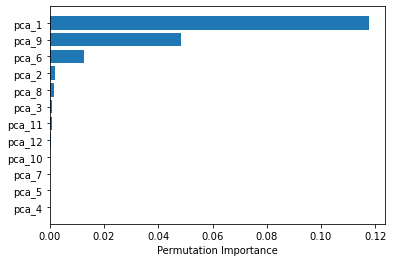

In [25]:
feature_names = np.array([f'pca_{x}' for x in range(1, 111)])
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [63]:
y_hat = final_pipe.predict(X_test)

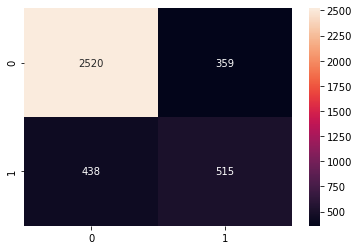

In [64]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, y_hat), annot=True, fmt="d")

In [67]:
final_pipe.score(X_test, y_test)

0.7920146137787056

f1-score 0.5637657361795292
matthews_corrcoef 0.4282479484661368


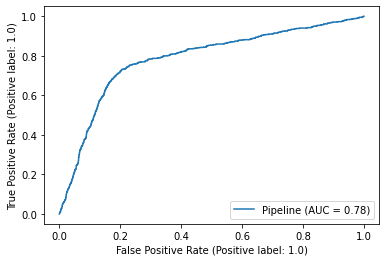

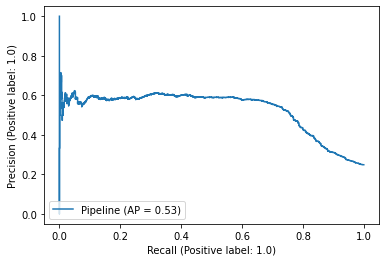

In [75]:
from sklearn.metrics import plot_roc_curve, f1_score, matthews_corrcoef, plot_precision_recall_curve

plot_roc_curve(final_pipe, X_test, y_test)
plot_precision_recall_curve(final_pipe, X_test, y_test)
print(f'f1-score {f1_score(y_test, y_hat)}')
print(f'matthews_corrcoef {matthews_corrcoef(y_test, y_hat)}')